# BidMPH v2 Monitor <br> Iquique y Alto Hospicio

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# Add the monitor directory to Python path
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import pprint
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.download import download_bid_data_1, download_bid_data
from src.calculations import share_bidding_algorithm, share_bid_price_matches, share_available_prices_length, share_bid_price_matches_by_len

## Parameters

In [4]:
CITY_ID = 4271
CITY_NAME = 'Alto_Hospicio'
ORDER_TYPE = 'auto_econom'

In [5]:
DATA_ROOT_PATH = pathlib.Path(f'data/city_id={CITY_ID}')
if not DATA_ROOT_PATH.exists():
    DATA_ROOT_PATH.mkdir(parents=True, exist_ok=True)

## Downlaoad

total

In [6]:
start_date = '2025-05-01'
end_date = '2025-06-20'

df_total = download_bid_data_1(start_date, end_date, CITY_ID, printBool=False)
df_total.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv', index=False)
print(f'df_total saved as {CITY_NAME}_total_bids.csv')

KeyboardInterrupt: 

df0 ('Before')

In [66]:
start_date = '2025-05-01'
end_date = '2025-05-19'

df0 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df0.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv', index=False)
print(
    'From', df0['utc_bid_dttm'].min(), 
    '\n to', df0['utc_bid_dttm'].max()
)
print(f'df0 saved as {CITY_NAME}_before_bids.csv')

From 2025-05-01 00:00:11+00:00 
 to 2025-05-19 23:59:57+00:00
df0 saved as Alto_Hospicio_before_bids.csv


df1 ('Test')

In [67]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df1.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv', index=False)
print(
    'From', df1['utc_bid_dttm'].min(), 
    '\n to', df1['utc_bid_dttm'].max()
)
print(f'df1 saved as {CITY_NAME}_test_bids.csv')

From 2025-05-20 00:00:08+00:00 
 to 2025-05-22 07:52:50+00:00
df1 saved as Alto_Hospicio_test_bids.csv


## Process Data

In [84]:
def parse_prices(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        items = s.strip('[]').split()
        return [float(item) for item in items] if items and items[0] != '' else []
    else:
        return []  # для None или некорректных значений

total

In [85]:
df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')

df_total = df_total[df_total['order_type'] == ORDER_TYPE]
df_total['bidding_algorithm_name'] = df_total['bidding_algorithm_name'].replace(np.nan, 'empty field')
# df_total['available_prices_currency'] = df_total['available_prices_currency'].apply(parse_prices)

In [86]:
# Убедитесь, что utc_bid_dttm — это datetime
df_total['utc_bid_dttm'] = pd.to_datetime(df_total['utc_bid_dttm'])

# Добавим колонку с датой (без времени)
df_total['date'] = df_total['utc_bid_dttm'].dt.date

# Группируем по дате и алгоритму, считаем количество
counts = df_total.groupby(['date', 'bidding_algorithm_name']).size().reset_index(name='count')

# Считаем общее количество по дням
total_per_day = df_total.groupby('date').size().reset_index(name='total')

# Объединяем, чтобы получить долю
counts = counts.merge(total_per_day, on='date')
counts['share'] = counts['count'] / counts['total']

# Пивотируем для удобства построения
pivot = counts.pivot(index='date', columns='bidding_algorithm_name', values='share').fillna(0)

df0

In [87]:
df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')
df0 = df0[df0['order_type'] == ORDER_TYPE]
df0['bidding_algorithm_name'] = df0['bidding_algorithm_name'].replace(np.nan, 'empty field')
df0['available_prices_currency'] = df0['available_prices_currency'].apply(parse_prices)

df1

In [88]:
df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')
df1 = df1[df1['order_type'] == ORDER_TYPE]
df1['bidding_algorithm_name'] = df1['bidding_algorithm_name'].replace(np.nan, 'empty field')
df1['available_prices_currency'] = df1['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_28612/1741608400.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')


## Result

In [89]:
def format_dict(d, precision=4):
    return {k: round(v, precision) if isinstance(v, float) else v for k, v in d.items()}

total

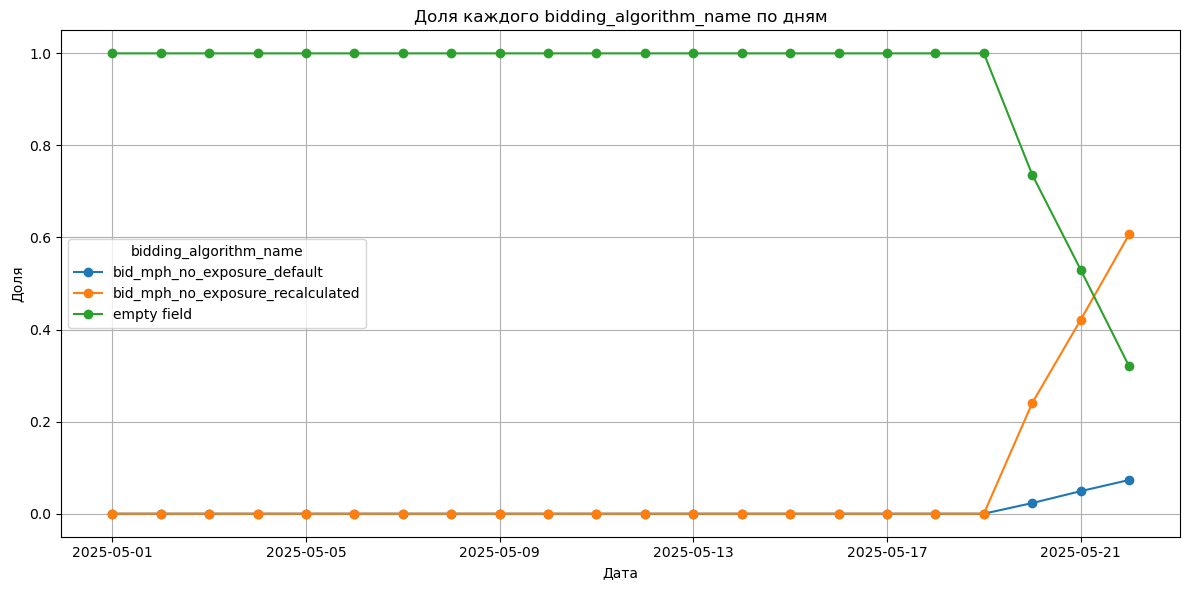

In [90]:
# Строим график
pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Доля каждого bidding_algorithm_name по дням')
plt.ylabel('Доля')
plt.xlabel('Дата')
plt.grid(True)
plt.legend(title='bidding_algorithm_name')
plt.tight_layout()
plt.show()

df0

In [91]:
df0['bidding_algorithm_name'].unique()

array(['empty field'], dtype=object)

In [92]:
share_algo = share_bidding_algorithm(df0)
share_matches = share_bid_price_matches(df0, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df0, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df0, algo_names=['empty field'], len_max=3)

In [93]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df0['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'empty field': 1.0}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 1.0,
 'total': 1313510}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.5,
                'share': 0.0},
 'between_0_1': {'done_share': 0.4667,
                 'share': 0.0},
 'between_1_2': {'done_share': 0.5714,
                 'share': 0.0},
 'match_first': {'done_share': 0.2506,
                 'share': 0.05},
 'match_second': {'done_share': 0.1399,
                  'share': 0.1771},
 'match_sp': {'done_share': 0.4238,
              'share': 0.6197},
 'match_third': {'done_share': 0.0724,
                 'share': 0.1493}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': nan,
                          'share': 0.0},
           'match_first': {'done_share': 0.0714,
                           

In [94]:
print(
    len(df0[(df0['option_number'] == 'startprice') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 1') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 2') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 3') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    )

0.6235437872570441 0.05000951648636097 0.17709800458313985 0.14933042001964203


df1

In [95]:
df1['bidding_algorithm_name'].unique()

array(['bid_mph_no_exposure_recalculated', 'empty field',
       'bid_mph_no_exposure_default'], dtype=object)

In [96]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['empty field'], len_max=3)

In [97]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.0402,
 'bid_mph_no_exposure_recalculated': 0.3614,
 'empty field': 0.5984}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0001,
 'len_2': 0.0,
 'len_3': 0.9999,
 'total': 91191}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': nan,
                'share': 0.0},
 'between_0_1': {'done_share': 0.0,
                 'share': 0.0},
 'between_1_2': {'done_share': 1.0,
                 'share': 0.0},
 'match_first': {'done_share': 0.2372,
                 'share': 0.0685},
 'match_second': {'done_share': 0.1266,
                  'share': 0.1751},
 'match_sp': {'done_share': 0.3861,
              'share': 0.5837},
 'match_third': {'done_share': 0.064,
                 'share': 0.169}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': nan,
                          'shar

In [98]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                         'bid_mph_no_exposure_default'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                               'bid_mph_no_exposure_default'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                                       'bid_mph_no_exposure_default'], len_max=3)

In [99]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.0402,
 'bid_mph_no_exposure_recalculated': 0.3614,
 'empty field': 0.5984}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.6598,
 'len_2': 0.1409,
 'len_3': 0.1993,
 'total': 61195}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 1.0,
                'share': 0.0},
 'between_0_1': {'done_share': 0.0,
                 'share': 0.0},
 'between_1_2': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.2164,
                 'share': 0.1963},
 'match_second': {'done_share': 0.1279,
                  'share': 0.0836},
 'match_sp': {'done_share': 0.4027,
              'share': 0.661},
 'match_third': {'done_share': 0.0749,
                 'share': 0.0554}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': 1.0,
                          '

## !

In [118]:
columns = ['bid_uuid', 'etr', 'eta', 'price_highrate_value', 'price_start_value', 'bid_price_currency', 
           'steps_recalc_default', 'bidding_algorithm_name', 'available_prices_currency', 
           'steps_real_perc', 'max_bid']

t = 200
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [119]:
def calculate_max_bid(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    # max_bid = (1+alpha) * max(Rec_price, Start_price) * (1 + (1+alpha) * max[0, (t2-t)]/(t1+t))
    max_bid = (1 + alpha) * max_price * (1 + time_diff_max / (t1 + t))

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [120]:
df_tmp = df1.sample(n=5).copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] != 'empty field'][columns].transpose()

,81184,27214
bid_uuid,0196f02d-35fd-7e51-b217-a15d9f311a1d,0196f1ae-67c2-7357-8dac-e9240d8746e7
etr,603.0,962.0
eta,300,300
price_highrate_value,2450.0,3150.0
price_start_value,3000.0,3150.0
bid_price_currency,3000.0,3500.0
steps_recalc_default,"[3300.0000000000005, 3600.0, 3900.0]","[3465.0000000000005, 3780.0, 4095.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[3300.0],"[3500.0, 3550.0]"
steps_real_perc,[1.1],"[1.1111111111111112, 1.126984126984127]"


Случай, где max_bid больше третьей опции, но bid_mph_no_exposure_recalculated <br>

In [121]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['case_check']].transpose()

,0,2,4,5,7,8,10,11,13,14,...,152553,152562,152563,152564,152565,152566,152571,152572,152573,152591
bid_uuid,0196f6cd-b378-7c1d-ba8f-e303fe08058e,0196f6ce-72fa-7b78-a651-891cd8e14745,0196eebd-2d4b-77d2-81e0-aeb9018c3e13,0196eeb7-e60d-777e-a57e-c67c684a1a88,0196eeb8-52a4-7d9c-88ca-44e141b21d50,0196eeae-f98a-778b-9df3-fbfea674a103,0196eeb6-994c-764c-87e0-1906e22d5279,0196eead-b00b-7e0b-96a5-65401b4ebd33,0196ef43-8017-7f58-aa56-f29b19a97a56,0196ef42-54ba-78aa-ade5-a2e2a96cb0d0,...,0196ef8e-eb1f-7cf5-975a-50d51d7e9dcd,0196ef10-e0a4-7eb0-9a23-5a4f8f09c550,0196ef00-9bd4-7e26-aff9-a30d267bd756,0196ef08-bf7a-7997-827a-1c8a17d3d203,0196ef0f-5b6a-7e49-b022-904c875a5e7f,0196ef10-ce90-7eb0-8dfb-822c92313912,0196eefc-5311-781d-a836-3a8e89560491,0196efcc-d961-7d12-9c62-1dd1152fd651,0196efce-c16f-7504-938b-af8a7550774f,0196ef1c-7138-785d-8f3c-4f3146e5fc8b
etr,NaN,NaN,510.0,254.0,254.0,1300.0,1745.0,480.0,265.0,741.0,...,1514.0,2165.0,1335.0,1617.0,2165.0,963.0,1807.0,1416.0,1684.0,1353.0
eta,180,360,120,180,180,300,420,240,120,120,...,420,240,300,360,240,240,660,120,180,480
price_highrate_value,2950.0,2350.0,2050.0,1700.0,1700.0,4150.0,5550.0,1850.0,1700.0,2700.0,...,4250.0,5600.0,5000.0,4550.0,5600.0,3700.0,4900.0,4750.0,4650.0,4400.0
price_start_value,2950.0,2600.0,2050.0,1950.0,1950.0,5400.0,5550.0,1950.0,1700.0,2700.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
bid_price_currency,3250.0,2650.0,2050.0,2150.0,1950.0,5400.0,5550.0,1950.0,1900.0,3000.0,...,5500.0,6000.0,5000.0,5000.0,6000.0,5000.0,5000.0,5500.0,5000.0,5000.0
steps_recalc_default,"[3245.0000000000005, 3540.0, 3835.0]","[2860.0000000000005, 3120.0, 3380.0]","[2255.0, 2460.0, 2665.0]","[2145.0, 2340.0, 2535.0]","[2145.0, 2340.0, 2535.0]","[5940.000000000001, 6480.0, 7020.0]","[6105.000000000001, 6660.0, 7215.0]","[2145.0, 2340.0, 2535.0]","[1870.0000000000002, 2040.0, 2210.0]","[2970.0000000000005, 3240.0, 3510.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[3250.0],"[2600.0, 2650.0]",[2300.0],[2150.0],[2150.0],[5950.0],[6150.0],[2150.0],[1900.0],[3000.0],...,[5500.0],"[5500.0, 6000.0, 6200.0]",[5500.0],[5500.0],"[5500.0, 6000.0, 6200.0]",[5500.0],"[5500.0, 5900.0]",[5500.0],[5500.0],[5500.0]
steps_real_perc,[1.1016949152542372],"[1.0, 1.0192307692307692]",[1.1219512195121952],[1.1025641025641026],[1.1025641025641026],[1.1018518518518519],[1.1081081081081081],[1.1025641025641026],[1.1176470588235294],[1.1111111111111112],...,[1.1],"[1.1, 1.2, 1.24]",[1.1],[1.1],"[1.1, 1.2, 1.24]",[1.1],"[1.1, 1.18]",[1.1],[1.1],[1.1]


In [122]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.961457
                                  True          0.038543
bid_mph_no_exposure_recalculated  False         0.211850
                                  True          0.788150
empty field                       False         0.273931
                                  True          0.726069
dtype: float64

In [123]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)].sample(n=5)[columns].transpose()

,40649,123682,58988,68916,77052
bid_uuid,0196ee27-c0b7-790f-b22e-b891a5ac33fd,0196f457-e13d-7ea4-9aaa-3d9e046d1f60,0196f605-dce9-7fce-87f5-1137ce072c48,0196f6ac-c23a-7c12-8fe1-440f134ef39e,0196f675-590d-7b18-a0c3-c51945ef1262
etr,630.0,405.0,441.0,NaN,437.0
eta,360,360,420,120,360
price_highrate_value,2600.0,1850.0,2200.0,2200.0,2250.0
price_start_value,2500.0,3000.0,2200.0,2000.0,2000.0
bid_price_currency,2900.0,3000.0,2500.0,2400.0,2000.0
steps_recalc_default,"[2750.0, 3000.0, 3250.0]","[3300.0000000000005, 3600.0, 3900.0]","[2420.0, 2640.0, 2860.0]","[2200.0, 2400.0, 2600.0]","[2200.0, 2400.0, 2600.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[2750.0, 2900.0]",[3300.0],"[2450.0, 2500.0]","[2200.0, 2400.0, 2450.0]","[2200.0, 2400.0, 2500.0]"
steps_real_perc,"[1.1, 1.16]",[1.1],"[1.1136363636363635, 1.1363636363636365]","[1.1, 1.2, 1.225]","[1.1, 1.2, 1.25]"


In [124]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)]['bid_uuid'].to_csv('recalculated_false_cases.csv', index=False)

Sabr MaxBid

In [125]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = max(row['eta'], t)
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [126]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,2,4,5,7,8,10,11,13,14,...,152553,152562,152563,152564,152565,152566,152571,152572,152573,152591
bid_uuid,0196f6cd-b378-7c1d-ba8f-e303fe08058e,0196f6ce-72fa-7b78-a651-891cd8e14745,0196eebd-2d4b-77d2-81e0-aeb9018c3e13,0196eeb7-e60d-777e-a57e-c67c684a1a88,0196eeb8-52a4-7d9c-88ca-44e141b21d50,0196eeae-f98a-778b-9df3-fbfea674a103,0196eeb6-994c-764c-87e0-1906e22d5279,0196eead-b00b-7e0b-96a5-65401b4ebd33,0196ef43-8017-7f58-aa56-f29b19a97a56,0196ef42-54ba-78aa-ade5-a2e2a96cb0d0,...,0196ef8e-eb1f-7cf5-975a-50d51d7e9dcd,0196ef10-e0a4-7eb0-9a23-5a4f8f09c550,0196ef00-9bd4-7e26-aff9-a30d267bd756,0196ef08-bf7a-7997-827a-1c8a17d3d203,0196ef0f-5b6a-7e49-b022-904c875a5e7f,0196ef10-ce90-7eb0-8dfb-822c92313912,0196eefc-5311-781d-a836-3a8e89560491,0196efcc-d961-7d12-9c62-1dd1152fd651,0196efce-c16f-7504-938b-af8a7550774f,0196ef1c-7138-785d-8f3c-4f3146e5fc8b
etr,NaN,NaN,510.0,254.0,254.0,1300.0,1745.0,480.0,265.0,741.0,...,1514.0,2165.0,1335.0,1617.0,2165.0,963.0,1807.0,1416.0,1684.0,1353.0
eta,180,360,120,180,180,300,420,240,120,120,...,420,240,300,360,240,240,660,120,180,480
price_highrate_value,2950.0,2350.0,2050.0,1700.0,1700.0,4150.0,5550.0,1850.0,1700.0,2700.0,...,4250.0,5600.0,5000.0,4550.0,5600.0,3700.0,4900.0,4750.0,4650.0,4400.0
price_start_value,2950.0,2600.0,2050.0,1950.0,1950.0,5400.0,5550.0,1950.0,1700.0,2700.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
bid_price_currency,3250.0,2650.0,2050.0,2150.0,1950.0,5400.0,5550.0,1950.0,1900.0,3000.0,...,5500.0,6000.0,5000.0,5000.0,6000.0,5000.0,5000.0,5500.0,5000.0,5000.0
steps_recalc_default,"[3245.0000000000005, 3540.0, 3835.0]","[2860.0000000000005, 3120.0, 3380.0]","[2255.0, 2460.0, 2665.0]","[2145.0, 2340.0, 2535.0]","[2145.0, 2340.0, 2535.0]","[5940.000000000001, 6480.0, 7020.0]","[6105.000000000001, 6660.0, 7215.0]","[2145.0, 2340.0, 2535.0]","[1870.0000000000002, 2040.0, 2210.0]","[2970.0000000000005, 3240.0, 3510.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[3250.0],"[2600.0, 2650.0]",[2300.0],[2150.0],[2150.0],[5950.0],[6150.0],[2150.0],[1900.0],[3000.0],...,[5500.0],"[5500.0, 6000.0, 6200.0]",[5500.0],[5500.0],"[5500.0, 6000.0, 6200.0]",[5500.0],"[5500.0, 5900.0]",[5500.0],[5500.0],[5500.0]
steps_real_perc,[1.1016949152542372],"[1.0, 1.0192307692307692]",[1.1219512195121952],[1.1025641025641026],[1.1025641025641026],[1.1018518518518519],[1.1081081081081081],[1.1025641025641026],[1.1176470588235294],[1.1111111111111112],...,[1.1],"[1.1, 1.2, 1.24]",[1.1],[1.1],"[1.1, 1.2, 1.24]",[1.1],"[1.1, 1.18]",[1.1],[1.1],[1.1]


In [127]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.961457
                                  True          0.038543
bid_mph_no_exposure_recalculated  False         0.211850
                                  True          0.788150
empty field                       False         0.273931
                                  True          0.726069
dtype: float64

Before experiment

In [128]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

""
bid_uuid
etr
eta
price_highrate_value
price_start_value
bid_price_currency
steps_recalc_default
bidding_algorithm_name
available_prices_currency
steps_real_perc


In [129]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
empty field             False         0.254727
                        True          0.745273
dtype: float64

Affected bids (not steps)

In [130]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['bid_price_currency'], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,1,2,3,4,5,6,7,8,9,...,1315458,1315459,1315460,1315461,1315462,1315463,1315464,1315465,1315466,1315467
bid_uuid,0196973d-b2b1-7aac-9076-8297e095cc00,019697d7-2900-717a-b07f-eb7a926ffa56,0196d675-5abb-75a1-bd34-65a89daedc95,0196d950-668d-7fc9-ad27-a0a75ae3096d,0196d950-8a77-7fcb-bd42-8ba6d7bfd9fb,0196d9dd-67e7-7037-b292-d3148a7ce816,0196e633-2cca-7e65-ac42-8cfa000e9315,0196e67a-07ef-7ff2-812b-432598202025,0196e971-0464-7e7d-be5f-3356f4ee8df0,0196eaa3-b0fd-7185-9052-48736f2895bf,...,0196ba5d-b0ec-7fef-b005-bd1ce2fb464c,0196bc34-a8fe-7364-9f00-682be5de86bf,0196b87d-e033-71c6-a39c-52553d7f7ca3,0196b814-da14-74ed-b688-8c356be72f26,0196bc7e-fd62-7f89-af7f-10f2703080a3,0196b666-f3e4-7882-a431-84b0406ca08c,0196b6df-98ba-713b-8045-02d348c53400,0196b87d-e552-71c6-8986-919713f99581,0196b6e0-255c-7200-ae52-0a0ebb104090,0196b26d-793a-7f12-bb59-6c26125b51c1
etr,672,1236,868,741,741,1191,1683,593,1218,1338,...,1352,1522,980,998,1303,1359,1558,980,1558,727
eta,360,300,420,120,240,300,300,240,420,60,...,240,240,300,180,180,300,180,360,480,300
price_highrate_value,2300.0,4250.0,2700.0,3600.0,3600.0,3150.0,5350.0,2700.0,4050.0,3700.0,...,4400.0,5150.0,4300.0,3700.0,4100.0,5100.0,4950.0,4300.0,4950.0,3650.0
price_start_value,2300.0,6000.0,2700.0,3100.0,3100.0,3150.0,6000.0,2700.0,5000.0,3700.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
bid_price_currency,3000.0,6000.0,3000.0,3450.0,3100.0,3150.0,5000.0,3550.0,6000.0,3700.0,...,5000.0,6500.0,6000.0,6000.0,6000.0,6500.0,6000.0,6000.0,6000.0,5000.0
steps_recalc_default,"[2530.0, 2760.0, 2990.0]","[6600.000000000001, 7200.0, 7800.0]","[2970.0000000000005, 3240.0, 3510.0]","[3410.0000000000005, 3720.0, 4030.0]","[3410.0000000000005, 3720.0, 4030.0]","[3465.0000000000005, 3780.0, 4095.0]","[6600.000000000001, 7200.0, 7800.0]","[2970.0000000000005, 3240.0, 3510.0]","[5500.0, 6000.0, 6500.0]","[4070.0000000000005, 4440.0, 4810.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[2550.0, 2800.0, 3000.0]","[6600.0, 7200.0, 7800.0]","[3000.0, 3250.0, 3550.0]","[3450.0, 3750.0, 4050.0]","[3450.0, 3750.0, 4050.0]","[3500.0, 3800.0, 4100.0]","[5500.0, 6000.0, 6500.0]","[3000.0, 3250.0, 3550.0]","[5500.0, 6000.0, 6500.0]","[4100.0, 4450.0, 4850.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
steps_real_perc,"[1.108695652173913, 1.2173913043478262, 1.3043...","[1.1, 1.2, 1.3]","[1.1111111111111112, 1.2037037037037037, 1.314...","[1.1129032258064515, 1.2096774193548387, 1.306...","[1.1129032258064515, 1.2096774193548387, 1.306...","[1.1111111111111112, 1.2063492063492063, 1.301...","[0.9166666666666666, 1.0, 1.0833333333333333]","[1.1111111111111112, 1.2037037037037037, 1.314...","[1.1, 1.2, 1.3]","[1.1081081081081081, 1.2027027027027026, 1.310...",...,"[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]"


In [131]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
empty field             False         0.804974
                        True          0.195026
dtype: float64

Choose Cities Query

In [136]:
def bids_data(start_date, stop_date, printBool=False):
    tmp_query = f"""
-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) AS first_row_by_accepted_tender,
    FROM `indriver-e6e40.emart.incity_detail`
    WHERE TRUE
        AND created_date_order_part >= DATE_SUB(DATE('{start_date}'), INTERVAL 1 DAY)
        AND created_date_order_part <= DATE_ADD(DATE('{stop_date}'), INTERVAL 1 DAY)
        AND DATE(TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', order_timestamp), timezone)) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

incity_details_base AS (
  SELECT *
  FROM incity_details_raw
  WHERE first_row_by_accepted_tender = 1
),

avg_rta_per_city_type AS (
    SELECT
        city_id,
        order_type,
        AVG(TIMESTAMP_DIFF(driverarrived_timestamp, driveraccept_timestamp, SECOND)) AS avg_rta_seconds_t -- This is 't'
    FROM incity_details_base
    WHERE is_order_arrived = TRUE
    GROUP BY city_id, order_type
),

order_global_info AS (
    SELECT
        uuid AS order_uuid,
        MAX(multiplier) AS multiplier,
        MAX(price_highrate_value / COALESCE(multiplier, 100)) AS price_highrate_value,
        MAX(payment_price_value / COALESCE(multiplier, 100)) AS price_start_value
    FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm`
    WHERE uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) >= DATE('{start_date}') 
      AND DATE(created_at) <= DATE('{stop_date}')
    GROUP BY uuid
),

bids_raw AS (
    SELECT
        uuid AS bid_uuid,
        order_uuid,
        price AS bid_price_value,
        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64) AS t2_eta_seconds, -- This is 't2'
        created_at AS utc_bid_dttm
    FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
    WHERE status = 'BID_STATUS_ACTIVE'
      AND order_uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

bids_enriched AS (
    SELECT
        b_raw.bid_uuid,
        b_raw.order_uuid,
        b_raw.utc_bid_dttm,
        b_raw.t2_eta_seconds,
        idb.city_id,
        idb.order_type,
        idb.tender_uuid AS order_accepted_tender_uuid,
        idb.is_order_done,
        idb.t1_duration_seconds,
        ogi.price_highrate_value,
        ogi.price_start_value,
        idb.start_price_incity_usd, -- Start_price (from incity_detail, for reference or alternative)
        b_raw.bid_price_value / COALESCE(ogi.multiplier, 100) AS bid_price_value,
        art.avg_rta_seconds_t
    FROM bids_raw b_raw
    LEFT JOIN incity_details_base idb ON b_raw.order_uuid = idb.order_uuid
    LEFT JOIN order_global_info ogi ON b_raw.order_uuid = ogi.order_uuid
    LEFT JOIN avg_rta_per_city_type art ON idb.city_id = art.city_id AND idb.order_type = art.order_type
),

-- Evaluate bids based on the formula
evaluated_bids AS (
    SELECT
        be.*,
        av.alpha_value,
        -- max_permissible_bid formula: (1+alpha) * max(Rec_price, Start_price) * (1 + max(0, (t2-t))/(t1+t))
        ( (1 + av.alpha_value) * GREATEST(COALESCE(be.price_highrate_value, 0), COALESCE(be.price_start_value, 0)) * -- Using COALESCE for safety, though filters should handle NULLs
            (1 + GREATEST(0, COALESCE(be.t2_eta_seconds, 0) - COALESCE(be.avg_rta_seconds_t, 0)) /
                 NULLIF( (COALESCE(be.t1_duration_seconds, 0) + COALESCE(be.avg_rta_seconds_t, 0)) , 0)
            )
        ) AS max_permissible_bid
    FROM bids_enriched be
    CROSS JOIN alpha_values av
    WHERE be.price_highrate_value IS NOT NULL      
      AND be.price_start_value IS NOT NULL 
      AND be.t1_duration_seconds IS NOT NULL 
      -- avg_rta_seconds_t (t) can be null (coalesced to 0 in formula)
      -- t2_eta_seconds (t2) can be null (coalesced to 0 in formula)
),

bids_with_bad_status AS (
    SELECT
        *,
        (max_permissible_bid IS NOT NULL AND bid_price_value > max_permissible_bid) AS is_bad_bid
    FROM evaluated_bids
),

-- Metric 1: Доля плохих бидов
overall_bad_bid_share AS (
    SELECT
        city_id,
        order_type,
        avg_rta_seconds_t,
        alpha_value,
        COUNTIF(max_permissible_bid IS NOT NULL) AS total_bids_rule_applicable,
        SUM(CAST(is_bad_bid AS INT64)) AS count_bad_bids,
        SAFE_DIVIDE(SUM(CAST(is_bad_bid AS INT64)), COUNTIF(max_permissible_bid IS NOT NULL)) AS share_of_bad_bids
    FROM bids_with_bad_status
    GROUP BY city_id, order_type, avg_rta_seconds_t, alpha_value
),

-- Metric 2: Доля завершенных заказов с плохим принятым бидом
-- First, identify completed orders and if their accepted tender was bad
accepted_tender_evaluation AS (
    SELECT
        bws.order_uuid,
        bws.city_id,
        bws.order_type,
        bws.alpha_value,
        bws.is_order_done,
        bws.is_bad_bid AS is_accepted_tender_bad,
        (bws.max_permissible_bid IS NOT NULL) AS is_accepted_tender_rule_applicable
    FROM bids_with_bad_status bws
    WHERE bws.bid_uuid = bws.order_accepted_tender_uuid -- Focus on the accepted bid
      AND bws.is_order_done = TRUE -- Only completed orders
),

-- Count completed orders where the accepted tender was bad (and rule was applicable)
done_orders_with_bad_tender_counts AS (
    SELECT
        city_id,
        order_type,
        alpha_value,
        COUNTIF(is_accepted_tender_bad = TRUE AND is_accepted_tender_rule_applicable = TRUE) AS num_done_orders_with_bad_tender
    FROM accepted_tender_evaluation
    GROUP BY city_id, order_type, alpha_value
),

-- Denominator for Metric 2: Total completed orders for each city/type
all_completed_orders_count AS (
    SELECT
        city_id,
        order_type,
        COUNT(DISTINCT order_uuid) AS count_all_completed_orders
    FROM incity_details_base -- Filtered by date range
    WHERE is_order_done = TRUE
    GROUP BY city_id, order_type
),

-- Calculate final Metric 2
final_metric_done_orders_bad_tender AS (
    SELECT
        acoc.city_id,
        acoc.order_type,
        av.alpha_value, -- Ensure all alphas are present for each city/type
        acoc.count_all_completed_orders,
        COALESCE(dowbtc.num_done_orders_with_bad_tender, 0) AS num_done_orders_with_bad_tender,
        SAFE_DIVIDE(
            COALESCE(dowbtc.num_done_orders_with_bad_tender, 0),
            acoc.count_all_completed_orders
        ) AS share_done_orders_with_bad_tender -- Denominator is ALL completed orders
    FROM all_completed_orders_count acoc
    CROSS JOIN alpha_values av -- Ensures all alphas are present for every city/type
    LEFT JOIN done_orders_with_bad_tender_counts dowbtc
        ON acoc.city_id = dowbtc.city_id
        AND acoc.order_type = dowbtc.order_type
        AND av.alpha_value = dowbtc.alpha_value
)

-- Combine all metrics for the final output
SELECT
    COALESCE(m1.city_id, m2.city_id)            AS city_id,
    COALESCE(m1.order_type, m2.order_type)      AS order_type,
    m1.avg_rta_seconds_t                        AS avg_rta,
    COALESCE(m1.alpha_value, m2.alpha_value)    AS alpha_value,
    m1.total_bids_rule_applicable               AS bids_count,               
    m1.count_bad_bids                           AS bad_bids_count,
    m1.share_of_bad_bids                        AS bad_bids_share,
    m2.count_all_completed_orders               AS rides_count,
    m2.num_done_orders_with_bad_tender          AS rides_badbids_count,
    m2.share_done_orders_with_bad_tender        AS rides_badbids_share
FROM overall_bad_bid_share m1
FULL JOIN final_metric_done_orders_bad_tender m2
    ON m1.city_id = m2.city_id
    AND m1.order_type = m2.order_type
    AND m1.alpha_value = m2.alpha_value
ORDER BY
    city_id,
    order_type,
    alpha_value;
    """
    
    if printBool:
        print(tmp_query)
    # query = f"""
    # SELECT *
    # FROM `analytics-dev-333113.temp.df_tender_{user_name}_exp`
    # """

    return client.query(tmp_query).result().to_dataframe()

In [137]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

start_date = '2025-05-01'
end_date = '2025-05-19'

df0_choosecities = bids_data(start_date=start_date, stop_date=end_date, printBool = True)
df0_choosecities.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df0_choosecities.csv', index=False)

# city_id=CITY_ID, order_type=ORDER_TYPE


-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) A

In [138]:
df0_choosecities[(df0_choosecities['city_id'] == CITY_ID) & 
                 (df0_choosecities['order_type'] == ORDER_TYPE)]

,city_id,order_type,avg_rta,alpha_value,bids_count,bad_bids_count,bad_bids_share,rides_count,rides_badbids_count,rides_badbids_share
4312,4271,auto_econom,198.552634,0.100,1301560,254836,0.195793,409016,30173,0.073770
4313,4271,auto_econom,198.552634,0.125,1301560,212409,0.163196,409016,22895,0.055976
4314,4271,auto_econom,198.552634,0.150,1301560,180559,0.138725,409016,19431,0.047507
4315,4271,auto_econom,198.552634,0.200,1301560,94530,0.072628,409016,8663,0.021180
4316,4271,auto_econom,198.552634,0.250,1301560,55818,0.042885,409016,4595,0.011234
4317,4271,auto_econom,198.552634,0.300,1301560,13929,0.010702,409016,1424,0.003482
4318,4271,auto_econom,198.552634,0.350,1301560,0,0.000000,409016,0,0.000000
4319,4271,auto_econom,198.552634,0.400,1301560,0,0.000000,409016,0,0.000000


OG bid approach

In [139]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

def download_og_bid_data(start_date, stop_date, city_id, order_type, printBool=False):
    tmp_query = f"""
    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = {city_id}
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <INT64>) AS available_prices,
                          CAST(NULL AS INT64)         AS contractor_id,
                          CAST(NULL AS INT64)         AS eta,
                          duration_in_seconds         AS duration_in_seconds,
                          CAST(NULL AS STRING)        AS accepted_status,
                          type_name                   AS order_type,
                          CAST(NULL AS STRING)        AS bidding_algorithm_name
                   FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm` t1
                        LEFT JOIN timezone_data tz
                            ON t1.city_id = tz.city_id
                        LEFT JOIN (SELECT order_uuid,
                                          duration_in_seconds,
                                   FROM `indriver-e6e40.emart.incity_detail`
                                   WHERE true
                                     AND city_id = {city_id}
                                     AND created_date_order_part BETWEEN '{start_date}' AND '{stop_date}') t2
                            ON t1.uuid = t2.order_uuid  
                   WHERE true
                     AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                     AND created_at BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), tz.timezone), INTERVAL 0 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), tz.timezone), INTERVAL 1
                                         DAY)
                     AND t1.city_id = {city_id}
                     AND type_name = '{order_type}'
                   QUALIFY ROW_NUMBER() OVER (PARTITION BY uuid, payment_price_value ORDER BY modified_at) = 1),

    accepted_bids AS (SELECT distinct
                             order_uuid AS order_uuid,
                             uuid       AS tender_uuid,
                             status     AS accepted_status,
                      FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
                      WHERE true
                        AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                          TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                          AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                        AND status = 'BID_STATUS_ACCEPTED'
                        AND order_uuid IN (SELECT order_uuid FROM rider_data)),
                        
    bid_data AS (SELECT distinct
                        CAST((ARRAY(SELECT DISTINCT city_id FROM rider_data LIMIT 1))[OFFSET(0)] AS INT64) AS city_id,
                        t.order_uuid                                                                       AS order_uuid,
                        price                                                                              AS price,
                        modified_at                                                                        AS modified_at_utc,
                        'bid_price'                                                                        AS price_type,
                        CAST(NULL AS INT64)                                                                AS price_highrate_value,
                        DENSE_RANK() OVER (ORDER BY t.order_uuid)                                          AS order_rn,
                        ROW_NUMBER() OVER (PARTITION BY t.order_uuid ORDER BY modified_at)                 AS tender_rn,
                        uuid                                                                               AS tender_uuid,
                        available_prices                                                                   AS available_prices,
                        contractor_id                                                                      AS contractor_id,
                        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64)                           AS eta,
                        CAST(NULL AS INT64)                                                                AS duration_in_seconds,
                        accepted_status                                                                    AS accepted_status,
                        CAST(NULL AS STRING)                                                               AS order_type,
                        bidding_algorithm_name                                                             AS bidding_algorithm_name
                 FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm` t
                 LEFT JOIN accepted_bids
                    ON t.order_uuid = accepted_bids.order_uuid
                        AND t.uuid = accepted_bids.tender_uuid
                 WHERE true
                   AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                     TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                     AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                   AND status = 'BID_STATUS_ACTIVE'
                   AND t.order_uuid IN (SELECT order_uuid FROM rider_data)),

    your_table AS (SELECT *
                   FROM (SELECT *
                         FROM rider_data
                         UNION ALL
                         SELECT *
                         FROM bid_data)
                   ORDER BY order_uuid, modified_at_utc),

    pass_groups AS (SELECT order_uuid,
                           price,
                           modified_at_utc,
                           price_type,
                           SUM(CASE WHEN price_type = 'rider_price' THEN 1 ELSE 0 END)
                               OVER (PARTITION BY order_uuid ORDER BY modified_at_utc) AS pass_group,
                           price_highrate_value,
                           available_prices,
                           contractor_id,
                           tender_uuid,
                           city_id,
                           eta,
                           duration_in_seconds,
                           accepted_status,
                           bidding_algorithm_name
                    FROM your_table),

    full_data_table AS (SELECT city_id,
                               order_uuid,
                               price,
                               price_type,
                               modified_at_utc,
                               available_prices,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid, pass_group ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS last_pass_price,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price_highrate_value END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS price_highrate_value,
                               contractor_id,
                               tender_uuid,
                               eta, 
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN duration_in_seconds END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS duration_in_seconds,
                               accepted_status,
                               bidding_algorithm_name
                        FROM pass_groups),

    options_assign AS (SELECT *,
                              CASE
                                  WHEN price_type = 'rider_price' THEN NULL
                                  ELSE
                                      COALESCE(
                                              (SELECT CASE
                                                          WHEN price = last_pass_price
                                                              THEN 'startprice'
                                                          WHEN price = available_prices[offset]
                                                              THEN 'option ' || CAST(offset + 1 AS STRING)
                                                          WHEN price < available_prices[SAFE_OFFSET(0)]
                                                              THEN 'option 1-'
                                                          WHEN price >
                                                               available_prices[SAFE_OFFSET(ARRAY_LENGTH(available_prices) - 1)]
                                                              THEN 'option ' || CAST(ARRAY_LENGTH(available_prices) AS STRING) || '+'
                                                          ELSE 'option ' || CAST(offset + 1 AS STRING) ||
                                                               (CASE WHEN price > available_prices[offset] THEN '+' ELSE '-' END)
                                                          END
                                               FROM UNNEST(available_prices) WITH OFFSET AS offset
                                               WHERE price = available_prices[offset]
                                                  OR (price < available_prices[offset] AND
                                                      (offset = 0 OR price > available_prices[offset - 1]))
                                                  OR (price > available_prices[offset] AND
                                                      (offset = ARRAY_LENGTH(available_prices) - 1 OR
                                                       price < available_prices[offset + 1]))
                                               LIMIT 1),
                                              'other'
                                      ) END AS option_number
                       FROM full_data_table),

    result AS (SELECT *,
               FROM options_assign AS t
                        LEFT JOIN timezone_data tz
                                  ON t.city_id = tz.city_id
               WHERE price_type = 'bid_price')

    SELECT *
    FROM result
    WHERE DATETIME_TRUNC(modified_at_utc, DAY) BETWEEN
      TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), DAY))
      AND TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), DAY))
    ORDER BY modified_at_utc
    """

    if printBool:
        print(tmp_query)
    
    return client.query(tmp_query).result().to_dataframe()

In [140]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1_og = download_og_bid_data(start_date=start_date, stop_date=end_date, city_id=CITY_ID, order_type=ORDER_TYPE, printBool = True)
df1_og.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df1_og.csv', index=False)


    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = 4271
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <

In [141]:
column_mapping = {
    'last_pass_price': 'price_start_value',
    'available_prices': 'available_prices_currency',
    'duration_in_seconds': 'etr',
    'price': 'bid_price_currency',
    'tender_uuid': 'bid_uuid'
}

df1_og = df1_og.rename(columns=column_mapping)
df1_og['bidding_algorithm_name'] = df1_og['bidding_algorithm_name'].replace('', 'empty field')

In [142]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    return max_bid

In [143]:
df_tmp = df1_og.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['option_number', 'max_bid_Sabr', 'case_check']].transpose()

,20833,20834,20835,20836,20837,20838,20839,20840,20843,20844,...,152590,152591,152592,152593,152595,156318,156319,156911,156919,156921
bid_uuid,0196ee27-b49d-7c43-9543-c21ae0c79cbd,0196ee27-b5d3-790f-9ec8-a0d3182877bd,0196ee27-b9c1-72a0-8dbc-1a40facaa1f9,0196ee27-bfe1-72a0-88d3-4fb1c210d802,0196ee27-c0b7-790f-b22e-b891a5ac33fd,0196ee27-c7f8-790f-8088-ab0a997554ee,0196ee27-c924-7513-953c-67b4af96fa02,0196ee27-d15d-7c44-a74d-854a082fcae3,0196ee27-df59-7044-9f2c-a0ee28385b52,0196ee27-e49f-7044-96f6-2c7e4553246e,...,0196f84b-0289-7bc9-9502-6b131d8cc27b,0196f84b-0c4e-78e7-8d0f-10c7d1725a40,0196f84b-1f1f-7053-8a95-714b7c7acf89,0196f84b-243c-7a77-b827-e2640275f33d,0196f84b-30cd-7a77-a6b0-7926d119bcff,0196f882-3423-76c9-bec0-97f403a114b9,0196f882-3862-76c9-9823-d9a28d099f1f,0196f88b-9c47-7703-813b-f089d93a546a,0196f88b-b25b-7131-a0a8-ab503bc48bba,0196f88b-bbfa-7cec-a1ea-878ce1dfe11e
etr,564,681,430,1369,630,630,180,1429,729,933,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
eta,240,120,300,60,360,420,120,300,360,240,...,180,420,120,120,300,120,240,180,600,360
price_highrate_value,210000.0,225000.0,175000.0,535000.0,260000.0,260000.0,150000.0,430000.0,230000.0,260000.0,...,150000.0,875000.0,235000.0,215000.0,215000.0,235000.0,235000.0,NaN,NaN,NaN
price_start_value,200000,200000,175000,535000,250000,250000,150000,500000,250000,300000,...,150000,875000,200000,215000,215000,235000,235000,350000,350000,350000
bid_price_currency,200000,200000,195000,535000,290000,250000,150000,500000,275000,300000,...,150000,965000,260000,215000,215000,260000,235000,385000,350000,350000
steps_recalc_default,"[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[192500.00000000003, 210000.0, 227500.0]","[588500.0, 642000.0, 695500.0]","[275000.0, 300000.0, 325000.0]","[275000.0, 300000.0, 325000.0]","[165000.0, 180000.0, 195000.0]","[550000.0, 600000.0, 650000.0]","[275000.0, 300000.0, 325000.0]","[330000.0, 360000.0, 390000.0]",...,"[165000.0, 180000.0, 195000.0]","[962500.0000000001, 1050000.0, 1137500.0]","[220000.00000000003, 240000.0, 260000.0]","[236500.00000000003, 258000.0, 279500.0]","[236500.00000000003, 258000.0, 279500.0]","[258500.00000000003, 282000.0, 305500.0]","[258500.00000000003, 282000.0, 305500.0]","[385000.00000000006, 420000.0, 455000.0]","[385000.00000000006, 420000.0, 455000.0]","[385000.00000000006, 420000.0, 455000.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[220000, 235000]","[220000, 240000, 250000]",[195000],[590000],"[275000, 290000]","[275000, 290000]",[165000],[550000],[275000],[330000],...,[165000],[965000],"[220000, 240000, 260000]",[240000],[240000],[260000],[260000],[385000],"[385000, 410000]",[385000]
steps_real_perc,"[1.1, 1.175]","[1.1, 1.2, 1.25]",[1.1142857142857143],[1.102803738317757],"[1.1, 1.16]","[1.1, 1.16]",[1.1],[1.1],[1.1],[1.1],...,[1.1],[1.1028571428571428],"[1.1, 1.2, 1.3]",[1.1162790697674418],[1.1162790697674418],[1.1063829787234043],[1.1063829787234043],[1.1],"[1.1, 1.1714285714285715]",[1.1]


In [144]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.858473
                                  True          0.141527
bid_mph_no_exposure_recalculated  False         0.205912
                                  True          0.794088
empty field                       False         0.266103
                                  True          0.733897
dtype: float64

Случай, где шаги бидов ниже старта: <br> bid_uuid == '0196f598-c67d-73b5-beb8-3bca5f30bc71'

In [145]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)
df_tmp['case_check'] = df_tmp.apply(lambda x: x['available_prices_currency'][0] / x['price_start_value'] < 1.1, axis=1)

columns += ['case_check']
df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns].transpose()

,1,3,6,9,12,19,22,25,26,28,...,152581,152582,152583,152584,152585,152586,152587,152588,152589,152590
bid_uuid,0196f6c7-db36-7b70-9325-5163050b2611,0196f6c6-8d81-7c1c-aa90-fed2e38b1143,0196eec1-68ae-77ed-b3b1-aefb311c39e6,0196eec4-0a1c-77ff-ba8d-cd4d93398ff7,0196f534-edcc-71dc-8a65-55aa13d169d4,0196f52f-9b0f-71d8-8e54-fd4bdb2a4386,0196ee37-6e07-72d8-badb-6f9b1c5db203,0196ee26-f428-7c40-8f77-86b2d7d21df7,0196ee35-f286-7c7f-bdcc-e50f15eea354,0196edfe-3326-7f93-b2d9-04869338a74e,...,0196eb64-f52d-73e8-adc2-24ee477d24de,0196ee51-fbfd-7105-87d7-b36c0e353f3f,0196ee49-2f1f-70dc-b514-d1dc48bccc03,0196eb76-4d82-7a29-859b-87f67d84fa42,0196eb74-d1aa-789d-92e1-e5c3553c4551,0196eb28-631b-73f1-a674-d5b5847f45dc,0196eb29-1616-78fd-a4bf-b0d1bedb31e3,0196edad-fb89-7e6a-86b8-351f04558606,0196ed99-7154-70cf-adfb-7713d34294a3,0196ed0b-6087-79f8-b1dc-bee805204ddb
etr,NaN,NaN,943.0,334.0,393.0,281.0,1032.0,1402.0,1059.0,521.0,...,978.0,1347.0,1761.0,1266.0,1095.0,935.0,935.0,1662.0,1517.0,862.0
eta,420,360,180,360,180,180,240,420,540,120,...,120,240,300,300,480,300,420,120,360,300
price_highrate_value,4900.0,5500.0,2900.0,2100.0,1950.0,1700.0,2800.0,3950.0,2650.0,1900.0,...,3800.0,4650.0,4850.0,4500.0,3500.0,3450.0,3450.0,5200.0,5850.0,3750.0
price_start_value,4900.0,5500.0,2900.0,2100.0,1950.0,1700.0,2800.0,3950.0,2650.0,1900.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5500.0,5500.0,5000.0,5000.0,5000.0
bid_price_currency,6400.0,5500.0,2900.0,2100.0,2150.0,2050.0,2800.0,3950.0,2650.0,1900.0,...,6500.0,6000.0,5000.0,5000.0,5000.0,6600.0,6600.0,5000.0,5000.0,5000.0
steps_recalc_default,"[5390.0, 5880.0, 6370.0]","[6050.000000000001, 6600.0, 7150.0]","[3190.0000000000005, 3480.0, 3770.0]","[2310.0, 2520.0, 2730.0]","[2145.0, 2340.0, 2535.0]","[1870.0000000000002, 2040.0, 2210.0]","[3080.0000000000005, 3360.0, 3640.0]","[4345.0, 4740.0, 5135.0]","[2915.0000000000005, 3180.0, 3445.0]","[2090.0, 2280.0, 2470.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[6050.000000000001, 6600.0, 7150.0]","[6050.000000000001, 6600.0, 7150.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[5400.0, 5900.0, 6400.0]","[6050.0, 6600.0, 7150.0]","[3200.0, 3500.0, 3800.0]","[2350.0, 2550.0, 2750.0]","[2150.0, 2350.0, 2550.0]","[1900.0, 2050.0, 2250.0]","[3100.0, 3400.0, 3650.0]","[4350.0, 4750.0, 5150.0]","[2950.0, 3200.0, 3450.0]","[2100.0, 2300.0, 2500.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[6050.0, 6600.0, 7150.0]","[6050.0, 6600.0, 7150.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
steps_real_perc,"[1.1020408163265305, 1.2040816326530612, 1.306...","[1.1, 1.2, 1.3]","[1.103448275862069, 1.206896551724138, 1.31034...","[1.119047619047619, 1.2142857142857142, 1.3095...","[1.1025641025641026, 1.205128205128205, 1.3076...","[1.1176470588235294, 1.2058823529411764, 1.323...","[1.1071428571428572, 1.2142857142857142, 1.303...","[1.1012658227848102, 1.2025316455696202, 1.303...","[1.1132075471698113, 1.2075471698113207, 1.301...","[1.105263157894737, 1.2105263157894737, 1.3157...",...,"[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]"


In [146]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.937122
                                  True          0.062878
bid_mph_no_exposure_recalculated  False         0.984293
                                  True          0.015707
empty field                       False         0.973572
                                  True          0.026428
dtype: float64